In [2]:
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import box
from shapely.ops import unary_union
from shapely.affinity import translate
from find_shifts import get_files, get_images
import cv2
%matplotlib widget

In [28]:
g = get_files()
image_data = get_images(g)
results = np.load("shifts.npz")
shifts, error, phasediff = results["shifts"], results["error"], results["phasediff"]
shifts[0]

array([[   0.,    0.,    0.],
       [   2.,  528.,    0.],
       [  -2., -206.,    0.],
       [ 436.,    2.,    0.],
       [ 437.,  530.,    0.],
       [   0.,    0.,    0.],
       [   0.,    0.,    0.],
       [   0.,    0.,    0.],
       [   0.,    0.,    0.]])

In [4]:
# add all the polygons corresponding to shifted images
polys = []
i=0
for j, shift in enumerate(shifts[i]):
    if np.any(np.isnan(shift)):
        continue
    ul = shifts[i,j][:2]
    lr = shifts[i,j][:2] + image_data[j].shape[:2]
    polys.append(box(*ul[:2], *lr[:2]))

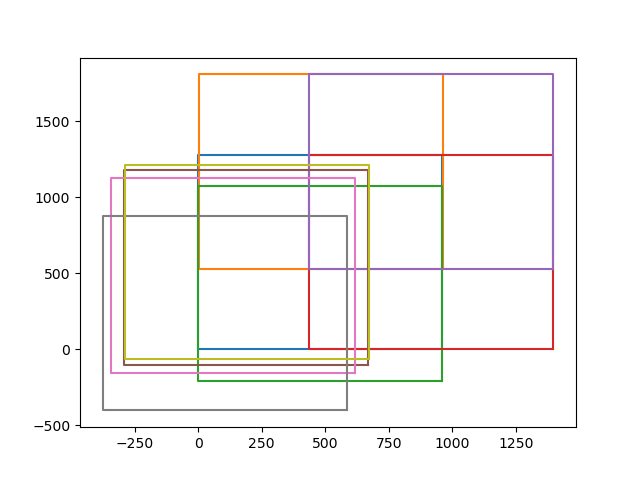

In [5]:
for poly in polys:
    plt.plot(*poly.exterior.xy)
plt.show()

In [27]:
# union and envelope polygons to get the shape of the overall destination image
boundary = unary_union(polys)
e = boundary.envelope
# b is the boundary of the evelope of the union of all the polygons- the smallest enclosing shape.
b = e.bounds
# r is the boundary, translated so the upper left is at the origin.
r = translate(e, -b[0], -b[1]).bounds

In [26]:
# Splat the images into the destination image
i = 0
n = np.full((int(r[2]), int(r[3]), 3), fill_value=0., dtype=np.uint32)
c = np.full((int(r[2]), int(r[3]), 3), fill_value=0., dtype=np.uint32)
print(n.shape)
print(shifts[i])
for j, shift in enumerate(shifts[i][:3]):
    if np.any(np.isnan(shift)):
        continue
    s = image_data[j].shape
    x1 = int(shift[0] - b[0])
    x2 = int(shift[0] - b[0] + s[0])
    y1 = int(shift[1] - b[1])
    y2 = int(shift[1] - b[1] + s[1])
    print(j, x1, y1, x2, y2)
    n[x1:x2, y1:y2] += image_data[j]
    c[x1:x2, y1:y2] += 1
    


(1774, 2210, 3)
[[   0.    0.    0.]
 [   2.  529.    0.]
 [  -2. -208.    0.]
 [ 436.    1.    0.]
 [ 438.  529.    0.]
 [-291. -101.    0.]
 [-341. -153.    0.]
 [-376. -401.    0.]
 [-288.  -66.    0.]]
0 376 401 1336 1681
1 378 930 1338 2210
2 374 193 1334 1473


C:\Users\dek\AppData\Local\Temp\ipykernel_4120\1177204303.py:1: RuntimeWarning: invalid value encountered in true_divide
  result = (n/c).astype(np.uint8)


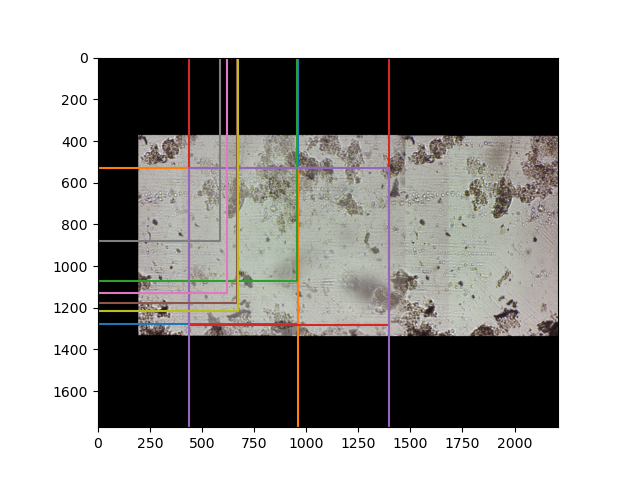

In [25]:
result = (n/c).astype(np.uint8)
plt.imshow(result)
plt.show()